In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


- VADER (Valence Aware Dictionary and sEntiment Reasoner)
+ Roberta Pretrained Model from Hugging Face
- Hugging Face Pipeline

## Step 0 Read in Data and Basics of NLTK

In [94]:
import pandas as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [95]:
# Read the data
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [96]:
# df.head(9)
df['Text'].values[12]

df.shape

df = df.head(800)

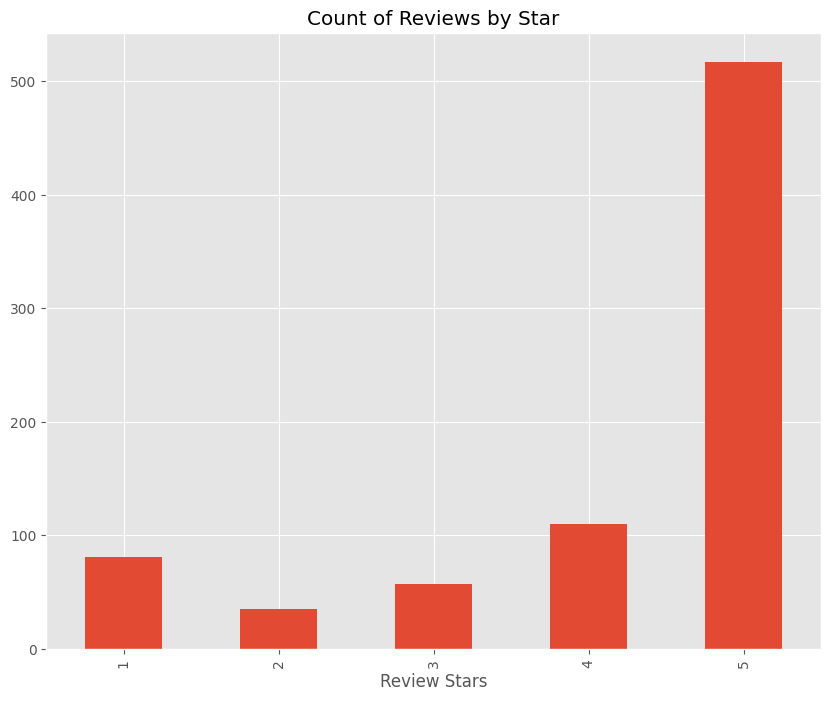

In [97]:
# EDA 
ax = df['Score'].value_counts().sort_index()\
.plot(kind='bar',title='Count of Reviews by Star',figsize=(10,8))

ax.set_xlabel('Review Stars')

plt.show()

## Basics of NLTK 

In [98]:
example = df['Text'].values[20]
print(example)

My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.


In [99]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['My', 'husband', 'is', 'a', 'Twizzlers', 'addict', '.', 'We', "'ve", 'bought']

In [100]:
tagg = nltk.pos_tag(tokens)
tagg[:10]

[('My', 'PRP$'),
 ('husband', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('Twizzlers', 'NNP'),
 ('addict', 'NN'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'ve", 'VBP'),
 ('bought', 'VBN')]

In [101]:
entities = nltk.chunk.ne_chunk(tagg)
entities.pprint()

(S
  My/PRP$
  husband/NN
  is/VBZ
  a/DT
  Twizzlers/NNP
  addict/NN
  ./.
  We/PRP
  've/VBP
  bought/VBN
  these/DT
  many/JJ
  times/NNS
  from/IN
  (GPE Amazon/NNP)
  because/IN
  we/PRP
  're/VBP
  government/NN
  employees/NNS
  living/VBG
  overseas/RB
  and/CC
  ca/MD
  n't/RB
  get/VB
  them/PRP
  in/IN
  the/DT
  country/NN
  we/PRP
  are/VBP
  assigned/VBN
  to/TO
  ./.
  They/PRP
  've/VBP
  always/RB
  been/VBN
  fresh/JJ
  and/CC
  tasty/JJ
  ,/,
  packed/VBN
  well/RB
  and/CC
  arrive/JJ
  in/IN
  a/DT
  timely/JJ
  manner/NN
  ./.)


## STEP 1 VADER Sentiment Scoring
- Stop word removal
- Each Word is scored and combined to a total score 

In [102]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

sia

In [103]:
# sia.polarity_scores('I am really happy today')
# sia.polarity_scores('Today is a really the worst day ever')
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6249}

In [104]:
# Setting the polarity for all the reviews in dataset
res = {}
for i,row in tqdm(df.iterrows(),total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/800 [00:00<?, ?it/s]

In [105]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df,how='left')

In [106]:
# DataFrame consisting of sentiment and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [107]:
# Let's see if the Vaders actually works or not
# In the sense that a 1 start review must have a more negative value \
#   Than a 5 star review with a more positive value


### Vaders Plot of Reviews

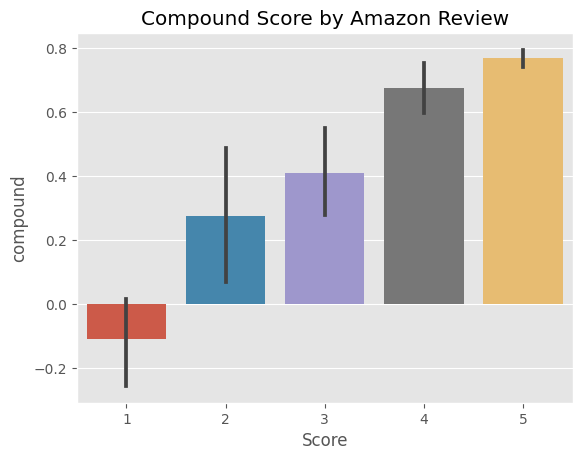

In [108]:
ax = sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon Review')
plt.show()

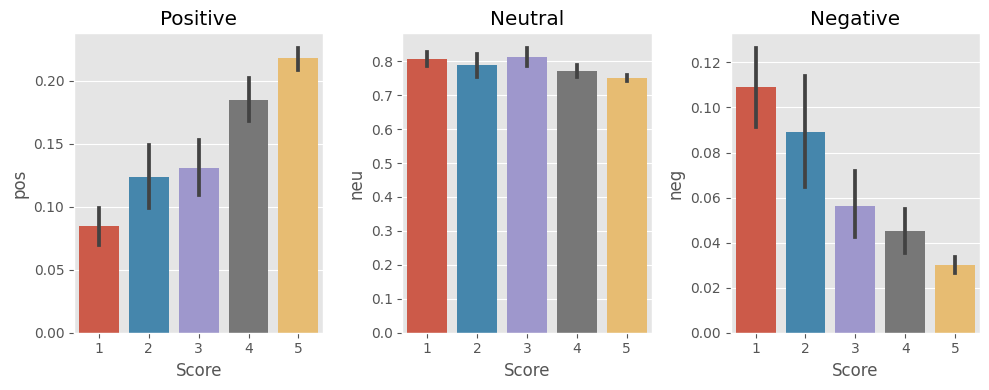

In [109]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
sns.barplot(data=vaders,x='Score',y='pos',ax=ax[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=ax[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 3 Pretrained Model from Hugging Face

In [110]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [111]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
token = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [112]:
print(example)
sia.polarity_scores(example)

#Run on Roberta
encoded_text = token(example,return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.
{'roberta_neg': 0.010422163, 'roberta_neu': 0.06525924, 'roberta_pos': 0.9243186}


In [113]:
def polarity_scores_roberta(example):
    encoded_text = token(example,return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos': scores[2]
    }
    return(scores_dict)

In [114]:
res = {}
for i,row in tqdm(df.iterrows(),total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key,value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result,**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for Id number {myid}')

  0%|          | 0/800 [00:00<?, ?it/s]

Broke for Id number 83
Broke for Id number 187
Broke for Id number 529
Broke for Id number 540
Broke for Id number 746


In [115]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'Id'})
results_df = results_df.merge(df,how='left')

In [116]:
results_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [117]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

### Comparison Scores of Both Models

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


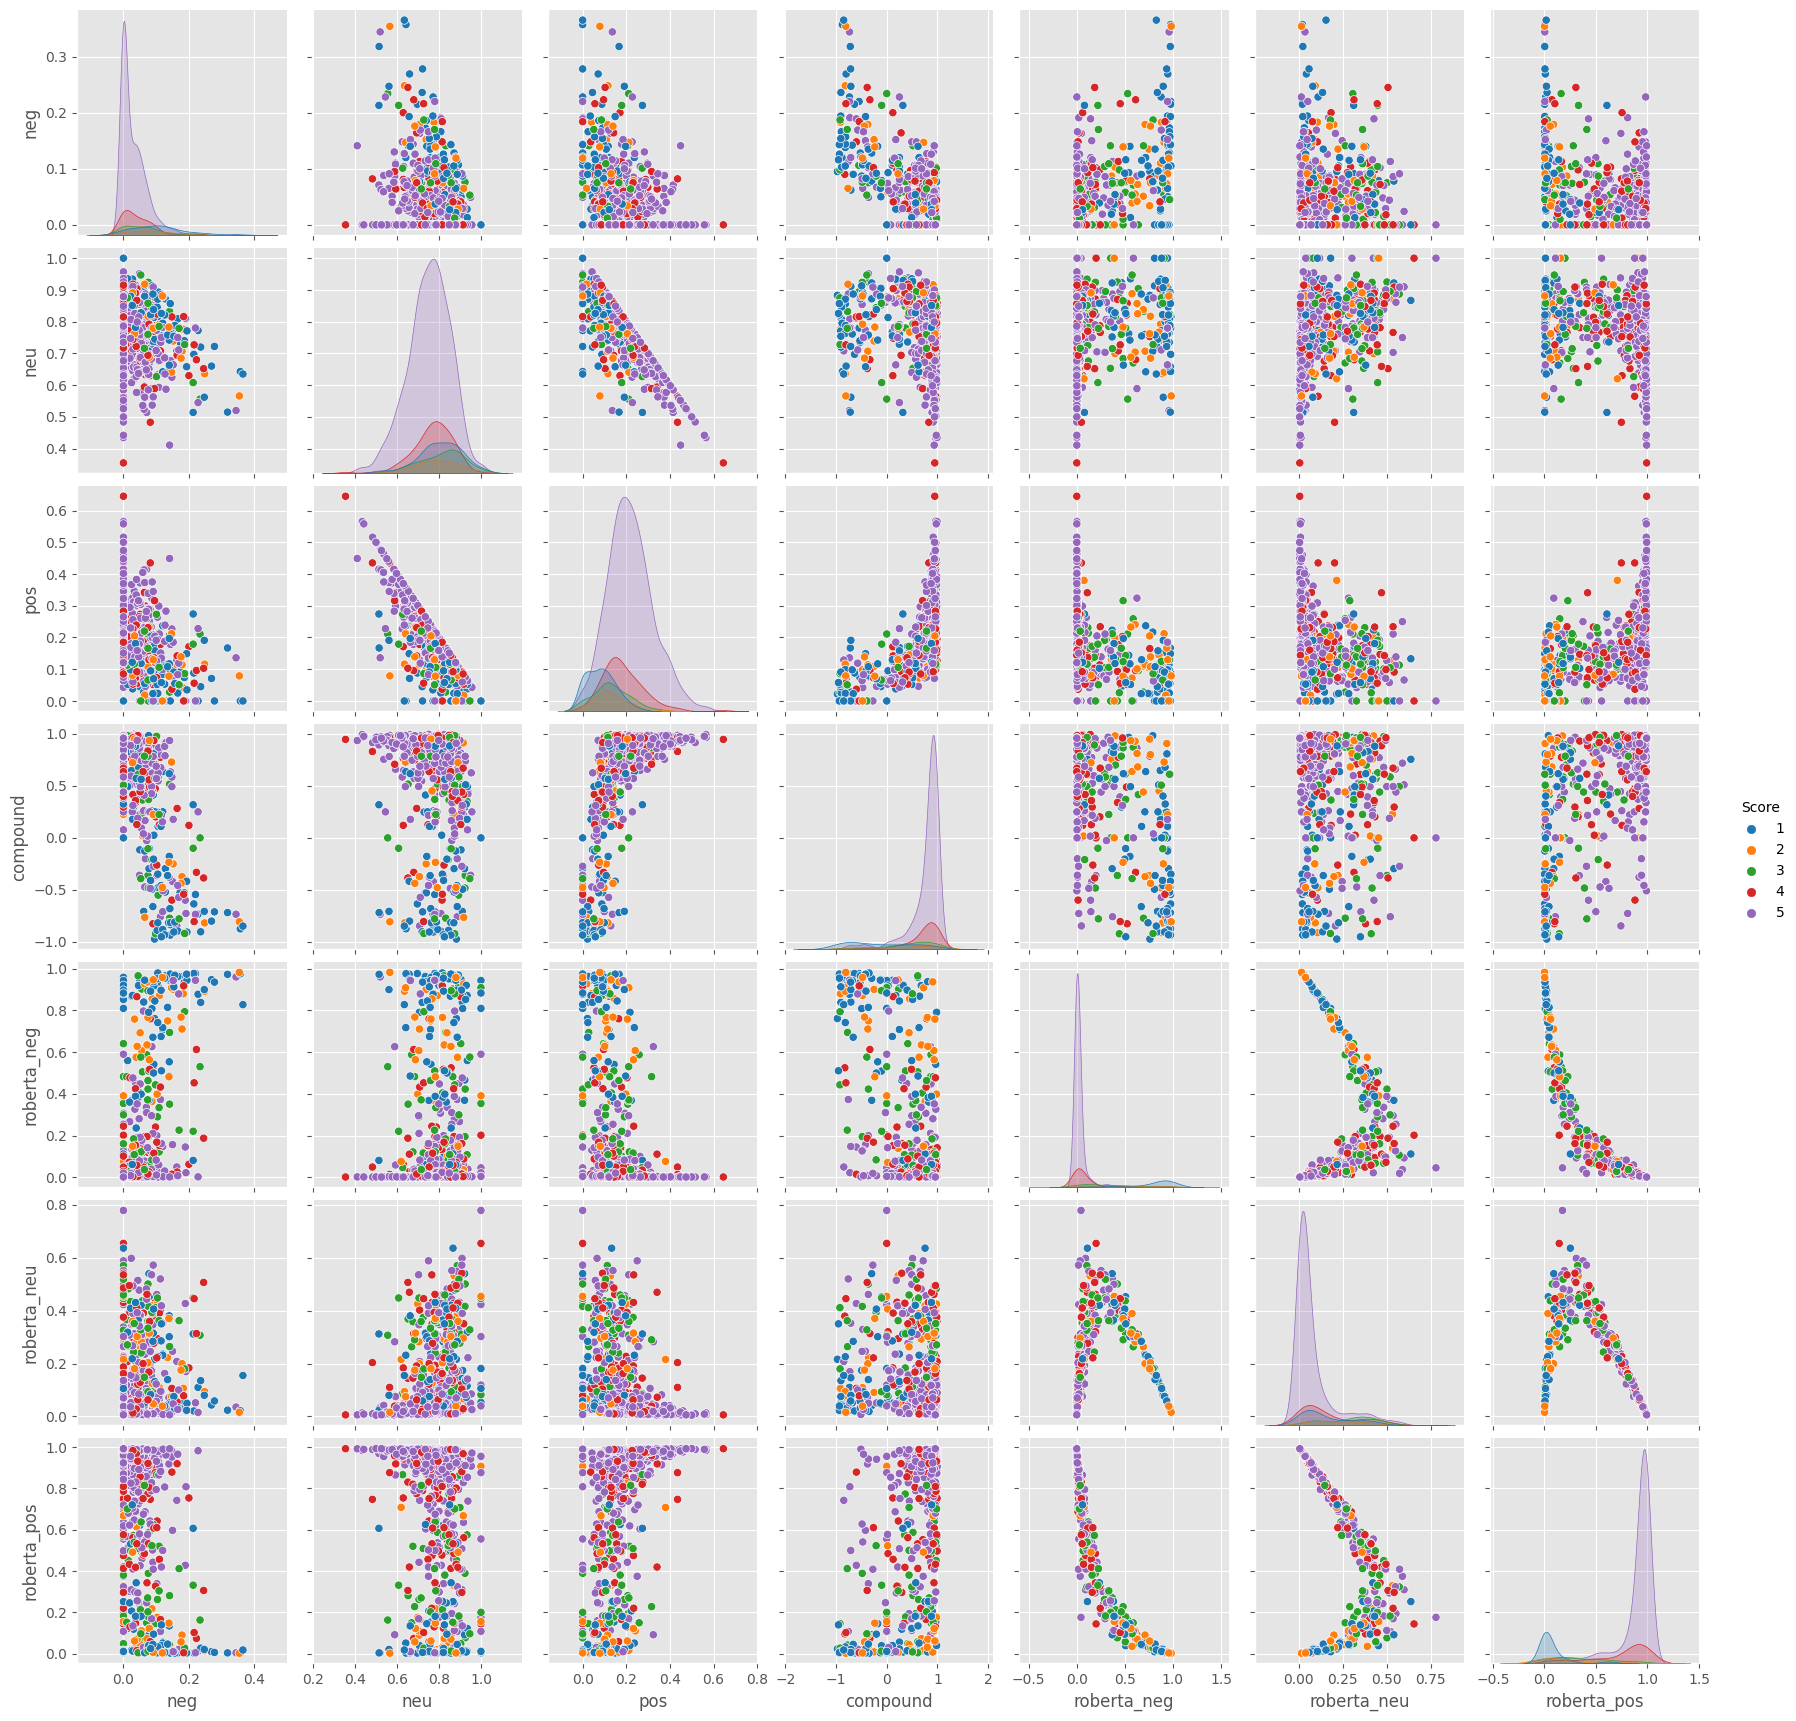

In [118]:
sns.pairplot(data=results_df,vars=['neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [119]:
results_df.query('Score == 1').sort_values('roberta_pos',ascending=False)\
['Text'].values[1]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [120]:
results_df.query('Score == 1').sort_values('pos',ascending=False)\
['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [122]:
results_df.query('Score == 5').sort_values('roberta_neg',ascending=False)\
['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [123]:
results_df.query('Score == 5').sort_values('neg',ascending=False)\
['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Transformers Pipeline

In [1]:
from transformers import pipeline

sent_pipe = pipeline("sentiment-analysis")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
sent_pipe("I love the concept of Neural Networks")

[{'label': 'POSITIVE', 'score': 0.9998410940170288}]